In [2]:
import pandas as pd
import os
from IPython.display import display
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem

from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
import pandas as pd
from rdkit.Chem import PandasTools
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit import rdBase
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import AllChem
from rdkit.Chem import rdFingerprintGenerator
from rdkit import DataStructs
from rdkit.Chem import MACCSkeys
from rdkit.Chem.Fingerprints import FingerprintMols
from descriptastorus.descriptors.DescriptorGenerator import MakeGenerator
# Importing Libraries
import pandas as pd
import warnings

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem, PandasTools
from rdkit.ML.Descriptors import MoleculeDescriptors

warnings.filterwarnings("ignore")
     


# Chemin relatif vers les données
data_path = "../data/raw_data/level_one_unifi_with_smiles.csv"
df = pd.read_csv(data_path)

# Dataset description

## Experimental data overview

The dataset consists of 185 reference compounds analyzed using a VION-IMS-QTOF mass spectrometer. The retention times were obtained through experimental measurements of pharmaceutical compounds, drugs, transformation products, biocides, and pesticides. These compounds represent diverse chemical structures found in environmental analysis. The dataset encompasses a range of molecules used in environmental monitoring, including parent compounds and their transformation products.

In [3]:
df = df[df['smiles'].notna() & (df['smiles'] != '')].reset_index(drop=True)

def canonicalize_smiles(smi):
    try:
        mol = Chem.MolFromSmiles(smi)
        if mol is not None:
            return Chem.MolToSmiles(mol)
        else:
            return None
    except:
        return None

# Appliquer la canonicalisation à la colonne SMILES
df['smiles'] = df['smiles'].apply(canonicalize_smiles)

mol_list = []

for smile in df['smiles']:
  mol = Chem.MolFromSmiles(smile)

  mol = Chem.AddHs(mol)
  mol_list.append(mol)
  
  

df = pd.concat([df, pd.DataFrame(mol_list, columns = (['mol']))], axis=1)
# Identifions d'abord la première occurrence de chaque molécule
first_instances = df.groupby('Molecule_Name').first().reset_index()

# Calculons la moyenne des RT pour chaque molécule
mean_rt = df.groupby('Molecule_Name')['Observed RT (min)'].mean()

# Remplaçons les RT dans le DataFrame des premières instances par les moyennes
first_instances['Observed RT (min)'] = first_instances['Molecule_Name'].map(mean_rt)

# Renommer le DataFrame final en df
df = first_instances



df = df.sample(frac=1).reset_index(drop=True)

df = df.drop(columns=['Adduct', 'Expected m/z', 'Observed m/z', 'Observed CCS (Å²)', 'InChI', 'mol', 'mol'])

df.head(10)


,Molecule_Name,Observed RT (min),smiles
0,Metolachlor-ESA,7.8660,CCc1cccc(C)c1N(C(=O)CS(=O)(=O)O)[C@H](C)COC
1,Spinosad A,13.7730,CCC1CCCC(OC2CCC(N(C)C)C(C)O2)[C@@H](C)C(=O)C2=...
2,4-Hydroxyphenylacetamide,2.3010,N=C(O)Cc1ccc(O)cc1
3,Atrazine-d5,9.5900,CCN=c1nc(Cl)[nH]c(=NC(C)C)[nH]1
4,Sulfamethoxazole,5.9780,Cc1cc(NS(=O)(=O)c2ccc(N)cc2)no1
5,MIT,1.4850,Cn1sccc1=O
6,Atrazine-desisopropyl,4.3750,CCN=c1[nH]c(Cl)nc(=N)[nH]1
7,Monuron,7.9955,CN(C)C(=O)Nc1ccc(Cl)cc1
8,Ranitidine S-Oxide,1.1550,CN/C(=C\[N+](=O)[O-])NCCS(=O)Cc1ccc(CN(C)C)o1
9,DCOIT,17.2150,CCCCCCCCn1sc(Cl)c(Cl)c1=O


In [4]:
df.shape

(185, 3)

## Chromatographic conditions


The chromatographic separation was performed using reversed-phase liquid chromatography (RPLC) on a Waters Acquity BEH C18 column (100 × 2.1 mm, 1.7 µm). The column temperature was maintained at 40°C throughout the analysis. The mobile phase consisted of ultrapure water with 0.1% formic acid (FA) as eluent A and acetonitrile with 0.1% formic acid as eluent B. The flow rate was set at 0.45 mL/min with an injection volume of 10 µL. Samples were stored at 10°C in the autosampler prior to injection.

In [5]:
#hide_input
import pandas as pd

# Tableau des conditions chromatographiques
chromatographic_conditions = pd.DataFrame({
   'Parameter': ['Column', 'Flow rate', 'Injection volume', 'Mobile phases', 'Temperature'],
   'Value': ['Waters Acquity BEH C18 (100 × 2.1 mm, 1.7 µm)', 
             '0.45 mL/min', 
             '10 µL', 
             'A: EUP + FA (0.1%) B: ACN + FA (0.1%)',
             '40°C']
})
chromatographic_conditions


,Parameter,Value
0,Column,"Waters Acquity BEH C18 (100 × 2.1 mm, 1.7 µm)"
1,Flow rate,0.45 mL/min
2,Injection volume,10 µL
3,Mobile phases,A: EUP + FA (0.1%) B: ACN + FA (0.1%)
4,Temperature,40°C


In [6]:

# Tableau du gradient
gradient_conditions = pd.DataFrame({
   'Time (min)': [0.00, 1.00, 21.50, 25.00, 30.00, 34.00],
   'A (%)': [98, 98, 98, 2, 2, 98],
   'B (%)': [2, 2, 2, 98, 98, 2]
})

gradient_conditions

,Time (min),A (%),B (%)
0,0.0,98,2
1,1.0,98,2
2,21.5,98,2
3,25.0,2,98
4,30.0,2,98
5,34.0,98,2


## Retention time analysis

The training dataset contains retention times measured under reversed-phase liquid chromatography conditions. The retention times span from 0.555 to 23.842 minutes, with a median value of 8.318 minutes. The distribution exhibits a standard deviation of 4.729 minutes and a skewness of 0.490.

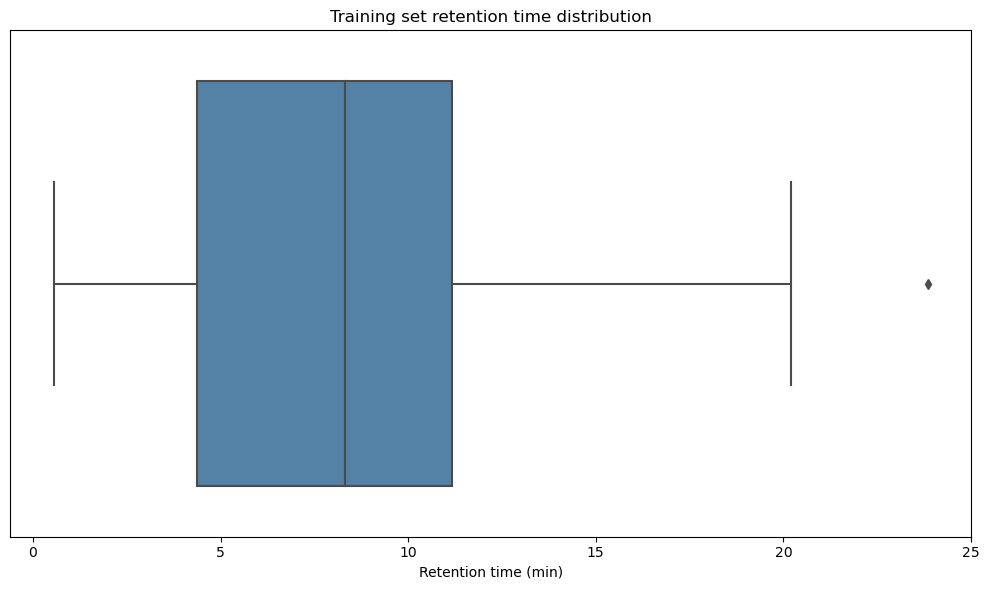

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

retention_time = df['Observed RT (min)']


import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.boxplot(x=retention_time, color='steelblue')
plt.title('Training set retention time distribution')
plt.xlabel('Retention time (min)')
plt.tick_params(axis='y', which='both', left=False, labelleft=False)
plt.tight_layout()
plt.show()


The boxplot reveals the distribution of retention times in the training set. The first quartile occurs at 5 minutes, while the third quartile extends to 10 minutes. Two distinct retention time regions emerge: early-eluting compounds before 5 minutes and late-eluting compounds after 15 minutes. One compound exhibits a retention time beyond 20 minutes, corresponding to the most hydrophobic molecule in the dataset.